# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [44 lines of output]
  Traceback (most recent call last):
    File "C:\Users\HP\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
      parsed = _parse_requirement(requirement_string)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\HP\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
      return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\HP\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
      url, specifier, marker = _parse_requirement_details(tokenizer)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\HP\anaconda3\Lib\site-packages\setuptools\_vendor\packag

In [2]:
!pip list

Package                                  Version
---------------------------------------- ---------------
absl-py                                  1.4.0
aiobotocore                              2.7.0
aiohttp                                  3.9.3
aioitertools                             0.7.1
aiosignal                                1.2.0
alabaster                                0.7.12
altair                                   5.0.1
anaconda-anon-usage                      0.4.4
anaconda-catalogs                        0.2.0
anaconda-client                          1.12.3
anaconda-cloud-auth                      0.4.1
anaconda-navigator                       2.5.4
anaconda-project                         0.11.1
annotated-types                          0.6.0
anthropic                                0.28.1
anyio                                    4.2.0
appdirs                                  1.4.4
archspec                                 0.2.3
argon2-cffi                              21.


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\HP\anaconda3\python.exe -m pip install --upgrade pip


In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [12]:
import cv2
import imghdr

In [13]:
data_dir = 'data' 

In [14]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [15]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [16]:
import numpy as np
from matplotlib import pyplot as plt

In [17]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [18]:
data_iterator = data.as_numpy_iterator()

In [19]:
batch = data_iterator.next()

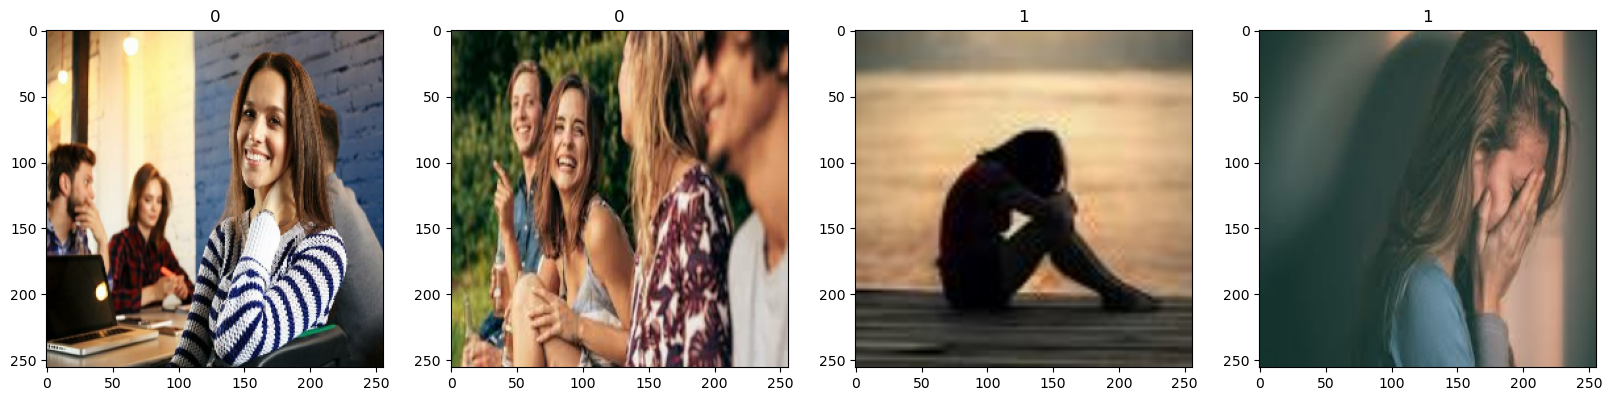

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [21]:
data = data.map(lambda x,y: (x/255, y))

In [22]:
data.as_numpy_iterator().next()

(array([[[[0.25592065, 0.279159  , 0.03616728],
          [0.28453586, 0.29672948, 0.05751379],
          [0.30050552, 0.28045344, 0.04123775],
          ...,
          [0.48162532, 0.3419041 , 0.03868719],
          [0.6775122 , 0.5398208 , 0.14070925],
          [0.72461706, 0.5873621 , 0.179519  ]],
 
         [[0.26281974, 0.28140318, 0.04048908],
          [0.2942577 , 0.2979743 , 0.05701411],
          [0.29992694, 0.27413732, 0.03758219],
          ...,
          [0.5098529 , 0.37112665, 0.0516219 ],
          [0.71641284, 0.57697684, 0.15991189],
          [0.75412446, 0.6146254 , 0.18882883]],
 
         [[0.26368162, 0.2721139 , 0.03279443],
          [0.30340222, 0.29627904, 0.05489017],
          [0.30842045, 0.27383867, 0.03835518],
          ...,
          [0.53804326, 0.39822668, 0.05162056],
          [0.74011195, 0.5971202 , 0.15187387],
          [0.7585826 , 0.6151543 , 0.1613017 ]],
 
         ...,
 
         [[0.46625024, 0.46625024, 0.5051749 ],
          [0.41357

# 5. Split Data

In [23]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [24]:
train_size

7

In [25]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [26]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [28]:
model = Sequential()

In [29]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\HP\Anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [31]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [33]:
logdir='logs'

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [36]:
hist = model.fit(train, epochs=8, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 576ms/step - accuracy: 0.9921 - loss: 0.0288 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 550ms/step - accuracy: 0.9975 - loss: 0.0108 - val_accuracy: 0.9844 - val_loss: 0.0171
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 554ms/step - accuracy: 0.9982 - loss: 0.0071 - val_accuracy: 0.9844 - val_loss: 0.0191
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 579ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 553ms/step - accuracy: 0.9975 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 0.0115
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 561ms/step - accuracy: 0.9858 - loss: 0.0125 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 554ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 580ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.9844 - val_loss: 0.0257


# 8. Plot Performance

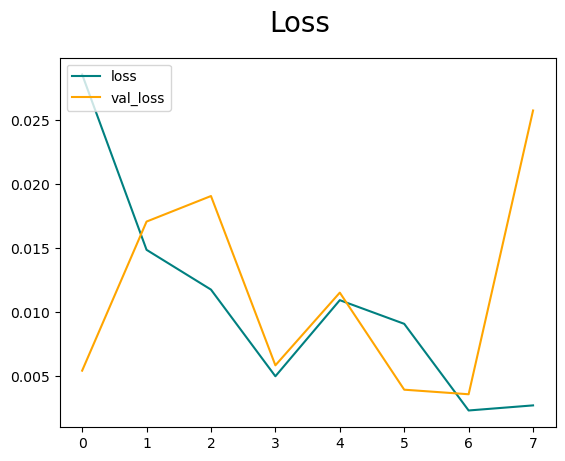

In [37]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

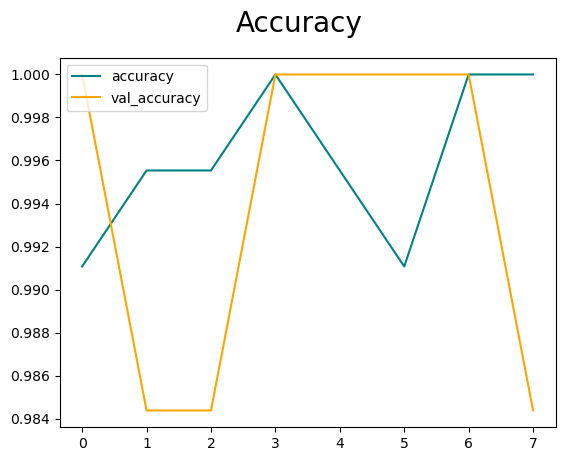

In [38]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [39]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [40]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [41]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


In [42]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9166667, shape=(), dtype=float32) tf.Tensor(0.9411765, shape=(), dtype=float32)


# 10. Test

In [43]:
import cv2

TypeError: Image data of dtype object cannot be converted to float

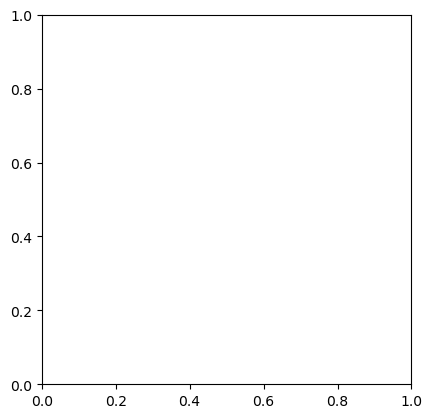

In [44]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

In [45]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [46]:
yhat = model.predict(np.expand_dims(resize/255, 0))

NameError: name 'resize' is not defined

In [47]:
yhat

array([[9.9999470e-01],
       [9.9999976e-01],
       [9.9999875e-01],
       [9.9991816e-01],
       [9.9992335e-01],
       [1.0187183e-07],
       [2.0253712e-01],
       [8.0461631e-04],
       [2.2226805e-11],
       [9.9991816e-01],
       [9.3303920e-10],
       [2.4322494e-08],
       [9.9999547e-01],
       [9.9862748e-01],
       [9.9999750e-01],
       [9.9968082e-01],
       [9.9971098e-01]], dtype=float32)

In [48]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)